# trajectory_analyze

particle trajectory analysis

file requirements:
- particle netcdf file generated by parcels after simulation
- the actual ocean data the particles ran on

In [27]:
%matplotlib inline

In [44]:
import sys
from datetime import timedelta, datetime
import math
import xarray as xr
import numpy as np
from parcels import FieldSet, ParticleSet, JITParticle
import matplotlib.pyplot as plt

In [29]:
d_nc = "west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river_lin.nc"
p_nc = "particledata/particle_tijuana_lin.nc"

In [30]:
d_ds = xr.open_dataset(d_nc)
p_ds = xr.open_dataset(p_nc)
fs = FieldSet.from_xarray_dataset(
        d_ds.copy(deep=True),
        dict(U="u",V="v"),
        dict(lat="lat",lon="lon",time="time")
    )
d_ds.close()
p_ds.close()

In [31]:
d_ds

<xarray.Dataset>
Dimensions:                (lat: 20, lon: 17, nv: 2, time: 169, time_1: 1)
Coordinates:
  * lat                    (lat) float32 32.53346 32.54245 ... 32.69528 32.70427
  * lon                    (lon) float32 -117.28391 -117.2735 ... -117.11733
  * time                   (time) datetime64[ns] 2020-06-16T21:00:00 ... 2020-06-23T21:00:00
    time_run               (time) datetime64[ns] ...
Dimensions without coordinates: nv, time_1
Data variables:
    time_bnds              (time_1, nv) int32 ...
    depth_bnds             (nv) float32 ...
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    time_offset            (time) datetime64[ns] ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
    u                      (time, lat, lon) float64 ...
    v                      (time, lat, lon) float64 ...
Attributes:
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202007060600siohfruwlsrtvuswc1km
    date_created:              2020-07-06T07:48:41Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        30.25
    geospatial_lat_max:        49.99204
    geospatial_lon_min:        -130.36
    geospatial_lon_max:        -115.805565
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2020-07-06T07:19:24Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               Coastal Observing Research and Development Cen...
    creator_type:              group
    creator_name:              HFRNet Administrators
    creator_email:             hfrnet.administrators@sio.ucsd.edu
    creator_url:               http://cordc.ucsd.edu/projects/mapping/
    naming_authority:          edu.ucsd.cordc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_1km_Resolutio...

In [32]:
p_ds

<xarray.Dataset>
Dimensions:     (obs: 53, traj: 420)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
    lifetime    (traj, obs) float32 ...
    spawntime   (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.0
    parcels_mesh:           spherical

In [33]:
def conv_to_dataarray(arr, darr_ref):
    """
    Args:
        arr (array-like)
        darr_ref (xr.DataArray): only used to label coordinates, dimensions, and metadata.
    """
    return xr.DataArray(arr, coords=darr_ref.coords, dims=darr_ref.dims, attrs=darr_ref.attrs)

def generate_mask(data):
    """
    Generates a boolean mask signifying which points in the data are invalid.
    
    Args:
        data (np.ndarray): an array with the shape of (time, lat, lon)
    """
    mask = np.zeros(data.shape, dtype=bool)
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            point = data.T[j][i]
            nan_vals = np.isnan(point)
            # if the point at (lat, lon) contains real data and nan values
            # mark those points as invalid
            if not nan_vals.all():
                mask.T[j][i][:] = np.where(nan_vals.flatten(), 1, 0)
    return mask

In [34]:
d_mask = conv_to_dataarray(generate_mask(d_ds["u"].values), d_ds["u"])

### check whether a particle collided with land

conditions:
- only check the latest position of a particle before it's deleted or stuck on land or something
- particle is on a position where even after fieldset interpolation, vector values are still zero

however, there may be some regions of actual ocean that just don't have data, so it's not foolproof

In [51]:
collided_land = np.zeros(p_ds["trajectory"].shape, dtype=bool)
lat_ls = []
lon_ls = []
for p in p_ds["trajectory"].values:
    p_iter = int(p[0])
    # find the first state of the particle where it got stuck on land something
    for step in range(len(p)):
        if np.isnan(p[step]):
            break
        time = p_ds["time"].values[p_iter, step]
        time_secs = p_ds["lifetime"].values[p_iter, step] + p_ds["spawntime"].values[p_iter, step]
        lat = p_ds["lat"].values[p_iter, step]
        lon = p_ds["lon"].values[p_iter, step]
        total_vel = abs(fs.U[time_secs, 0, lat, lon]) + abs(fs.V[time_secs, 0, lat, lon])
        # first, check if the vector speed at that coordinate is 0 after interpolation
        # second, check if the particle is not in an invalid coordinate (a coordinate supposed to have data)
        if total_vel <= sys.float_info.epsilon and not d_mask.sel(time=time, lat=lat, lon=lon, method="nearest"):
            lat_ls.append(lat)
            lon_ls.append(lon)
            print(f"particle {p_iter} beached at time {time}")
            print(f"    spawn time: {p_ds['time'].values[p_iter, 0]}")
            print(f"    spawn coord: ({p_ds['lat'].values[p_iter, 0]}, {p_ds['lon'].values[p_iter, 0]})")
            break

particle 30 beached at time 2020-06-18T09:00:00.000000000
    spawn time: 2020-06-17T09:00:00.000000000
    spawn coord: (32.5516242980957, -117.13677215576172)
particle 31 beached at time 2020-06-18T09:00:00.000000000
    spawn time: 2020-06-17T09:00:00.000000000
    spawn coord: (32.5531005859375, -117.13734436035156)
particle 32 beached at time 2020-06-18T09:00:00.000000000
    spawn time: 2020-06-17T09:00:00.000000000
    spawn coord: (32.557010650634766, -117.13938903808594)
particle 33 beached at time 2020-06-18T09:00:00.000000000
    spawn time: 2020-06-17T09:00:00.000000000
    spawn coord: (32.55614471435547, -117.13753509521484)
particle 34 beached at time 2020-06-18T09:00:00.000000000
    spawn time: 2020-06-17T09:00:00.000000000
    spawn coord: (32.5517463684082, -117.13676452636719)
particle 35 beached at time 2020-06-18T09:00:00.000000000
    spawn time: 2020-06-17T09:00:00.000000000
    spawn coord: (32.55757522583008, -117.1368637084961)
particle 36 beached at time 202

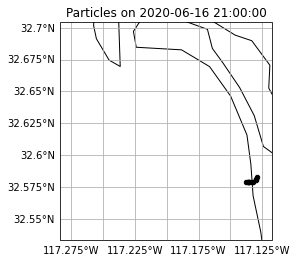

In [49]:
# stuff coordinates into a particleset for easy graphing, not actually running anything
pset = ParticleSet(fs, pclass=JITParticle, lon=lon_ls, lat=lat_ls)
pset.show()